### Import necessary Python libraries




In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

import os
import random

from google.colab import drive

### connect Google Drive with Colab

In [2]:
drive.mount('/content/drive')
print("Connected to Google Drive")

Mounted at /content/drive
Connected to Google Drive


## Settings for AI Training

In [3]:
# @markdown ### Train a new AI model?:
train_moedel = True # @param {type:"boolean"}

In [4]:
# Dataset specific parameters
# @markdown ### Enter a file path:
folder_path = "/content/drive/MyDrive/info_vis_AI_2025" # @param {type:"string"}

is_poly_surface = True
except_data_shape = (8,3,8,8)
use_padded_data = True


save_model = True
# @markdown ### Enter Name of AI Model:
model_name = "My_first_AI_Model" # @param {type:"string"}
save_model_location = folder_path +"/models" + "/" + model_name
if not os.path.exists(save_model_location):
    os.makedirs(save_model_location)

# @markdown ### Enter Name of AI generated Geometries:
save_geo_folder = folder_path +"/geometries" + "/" + model_name
if not os.path.exists(save_geo_folder):
    os.makedirs(save_geo_folder)
save_geo_name = "New_Geometry" # @param {type:"string"}

model_type = "VAE"

model_name = model_name + ".pth"


In [5]:
# @markdown ### AI Model Parameters
number_of_neurons = [512,256,128] #@param
latent_space_dim = 32 #@param {type:"integer"}
# @markdown ---

# @markdown ### AI Training Parameters
batch_size = 16 #@param {type:"integer"}
epochs = 300 #@param {type:"integer"}
learning_rate = 0.0001 #@param {type:"number"}
kld_multiplier = .5 #@param {type:"number"}




### Check if correct Google Colab Hardware is sellected ('CUDA/GPU')

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda':
    print("Using CUDA/GPU - all good!")
if device.type == 'cpu':
    print("Warning wrong Hardware selected - Go to 'Runtime' -> 'Change Runtime Type' -> select a Hardweare with GPU")

Using CUDA/GPU - all good!


## Helper Funktions

In [7]:
def visualize_points(tensor, point_color = 'b', remove_padding = True, remove_threshold = -0.5):
    # ensure that the tensor is a numpy array if it is a torch tensor convert it to numpy
    if isinstance(tensor, torch.Tensor):
        # put the tensor on the cpu
        tensor = tensor.cpu()
        tensor = tensor.detach().numpy()

    if len(tensor.shape) == 3:
        visualize_surface(tensor, point_color, remove_padding, remove_threshold)
    elif len(tensor.shape) == 4:
        visualize_poly_surface(tensor, point_color, remove_padding, remove_threshold)
    else:
        raise ValueError("The input tensor must have main shape of 3 or 4")


def visualize_surface(tensor, point_color, remove_padding, remove_threshold):

    if tensor.shape[0] == 4:
    #detach the last matrix from the tensor
        tensor = tensor[0:3, :]
    elif tensor.shape[0] != 3:
        raise ValueError("The input tensor must have main shape of 3 or 4")

    tensor = tensor.reshape(3, -1).T

    if remove_padding:
        #remove all rows and columns that are all -1s
        tensor = tensor[~np.all(tensor < remove_threshold, axis=1)]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(tensor[:, 0], tensor[:, 1], tensor[:, 2], c=point_color)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    plt.show()


def visualize_poly_surface(tensor, point_color, remove_padding, remove_threshold):
    if tensor.shape[1] == 4:
        #detach the last matrix from the tensor
        tensor = tensor[:,0:3,:,:]
        print(tensor.shape)
    elif tensor.shape[1] != 3:
        raise ValueError("The input tensor must have main shape of 3 or 4")

    poly_surface = []
    for surface in tensor:
        surface = surface.reshape(3, -1).T

        if remove_padding:
            #remove all rows and columns that are all -1s
            surface = surface[~np.all(surface < remove_threshold, axis=1)]

        #print(surface.shape)
        if surface.shape[0] > 0:
            poly_surface.append(surface)

    poly_surface = np.array(poly_surface).reshape(-1, 3)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(poly_surface[:, 0],poly_surface[:, 1],poly_surface[:, 2], c=point_color)
    # fix the x,y,z limits from 0 to 1
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    plt.show()


In [8]:
def visualize_heatmaps(array_3d, save_path=None):

    # If array is an instance of torch tensor, convert it to numpy
    if isinstance(array_3d, torch.Tensor):
        array_3d = array_3d.cpu().detach().numpy()

    def surface_heat_map(array_3d, num_iterations, figsize=(15, 5)):
        fig, axes = plt.subplots(num_iterations, 3, figsize=(15, 5 * num_iterations))
        cmap = plt.cm.viridis
        cmap.set_bad(color='black')  # Set color for masked values

        # Ensure axes is always a 2D array for consistent indexing
        if num_iterations == 1:
            axes = np.expand_dims(axes, axis=0)

        for i in range(num_iterations):
            for j in range(3):
                slice_2d = array_3d[i, j]

                # Create a masked array where -1 values are masked
                masked_slice = np.ma.masked_where(slice_2d == -1, slice_2d)

                ax = axes[i, j]
                im = ax.imshow(masked_slice, cmap=cmap, vmin=-1, vmax=1)
                ax.set_title(f'Iteration {i+1}, Slice {["X", "Y", "Z"][j]}')
                fig.colorbar(im, ax=ax)

        # Set tight layout
        plt.tight_layout()

        # Set title
        plt.suptitle('Heatmap Slices', fontsize=16)

        if save_path:
            plt.savefig(os.path.join(save_path, 'heatmap_slices.png'))
        else:
            plt.show()
        plt.close()

    if len(array_3d.shape) == 3:
        if array_3d.shape[0] == 4:
            # Detach the last matrix from the tensor
            array_3d = array_3d[0:3, :]
        elif array_3d.shape[0] != 3:
            raise ValueError("The input tensor must have main shape of 3 or 4")

        surface_heat_map(array_3d[np.newaxis, :], 1)  # Add a new axis to make it 4D

    elif len(array_3d.shape) == 4:
        if array_3d.shape[1] == 4:
            # Detach the last matrix from the tensor
            array_3d = array_3d[:, 0:3, :]
        elif array_3d.shape[1] != 3:
            raise ValueError("The input tensor must have main shape of 3 or 4")

        surface_heat_map(array_3d, array_3d.shape[0])  # Pass the number of iterations

    else:
        raise ValueError("The input tensor is not Surface or Poly Surface")

# Example usage
# Assuming data is of shape (num_iterations, 3, height, width)
#num_iterations = 1
#height, width = 16, 16
#data = np.random.rand(num_iterations, 3, height, width)

#visualize_heatmaps(data)

## Import Dataset

<ipython-input-9-3475ae123c69>:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  train_data = torch.tensor(train_data, dtype=torch.float32, device=device)


Number of training samples: 2795
Number of testing samples: 311
Shape of the data:  torch.Size([8, 3, 8, 8])
Type of the data:  <class 'torch.Tensor'>


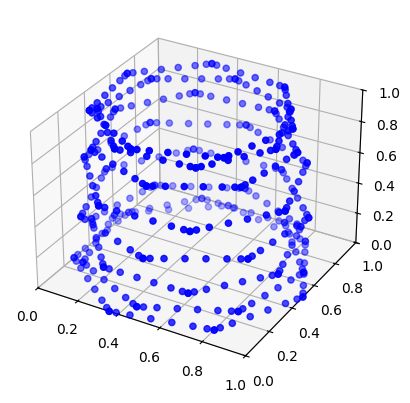

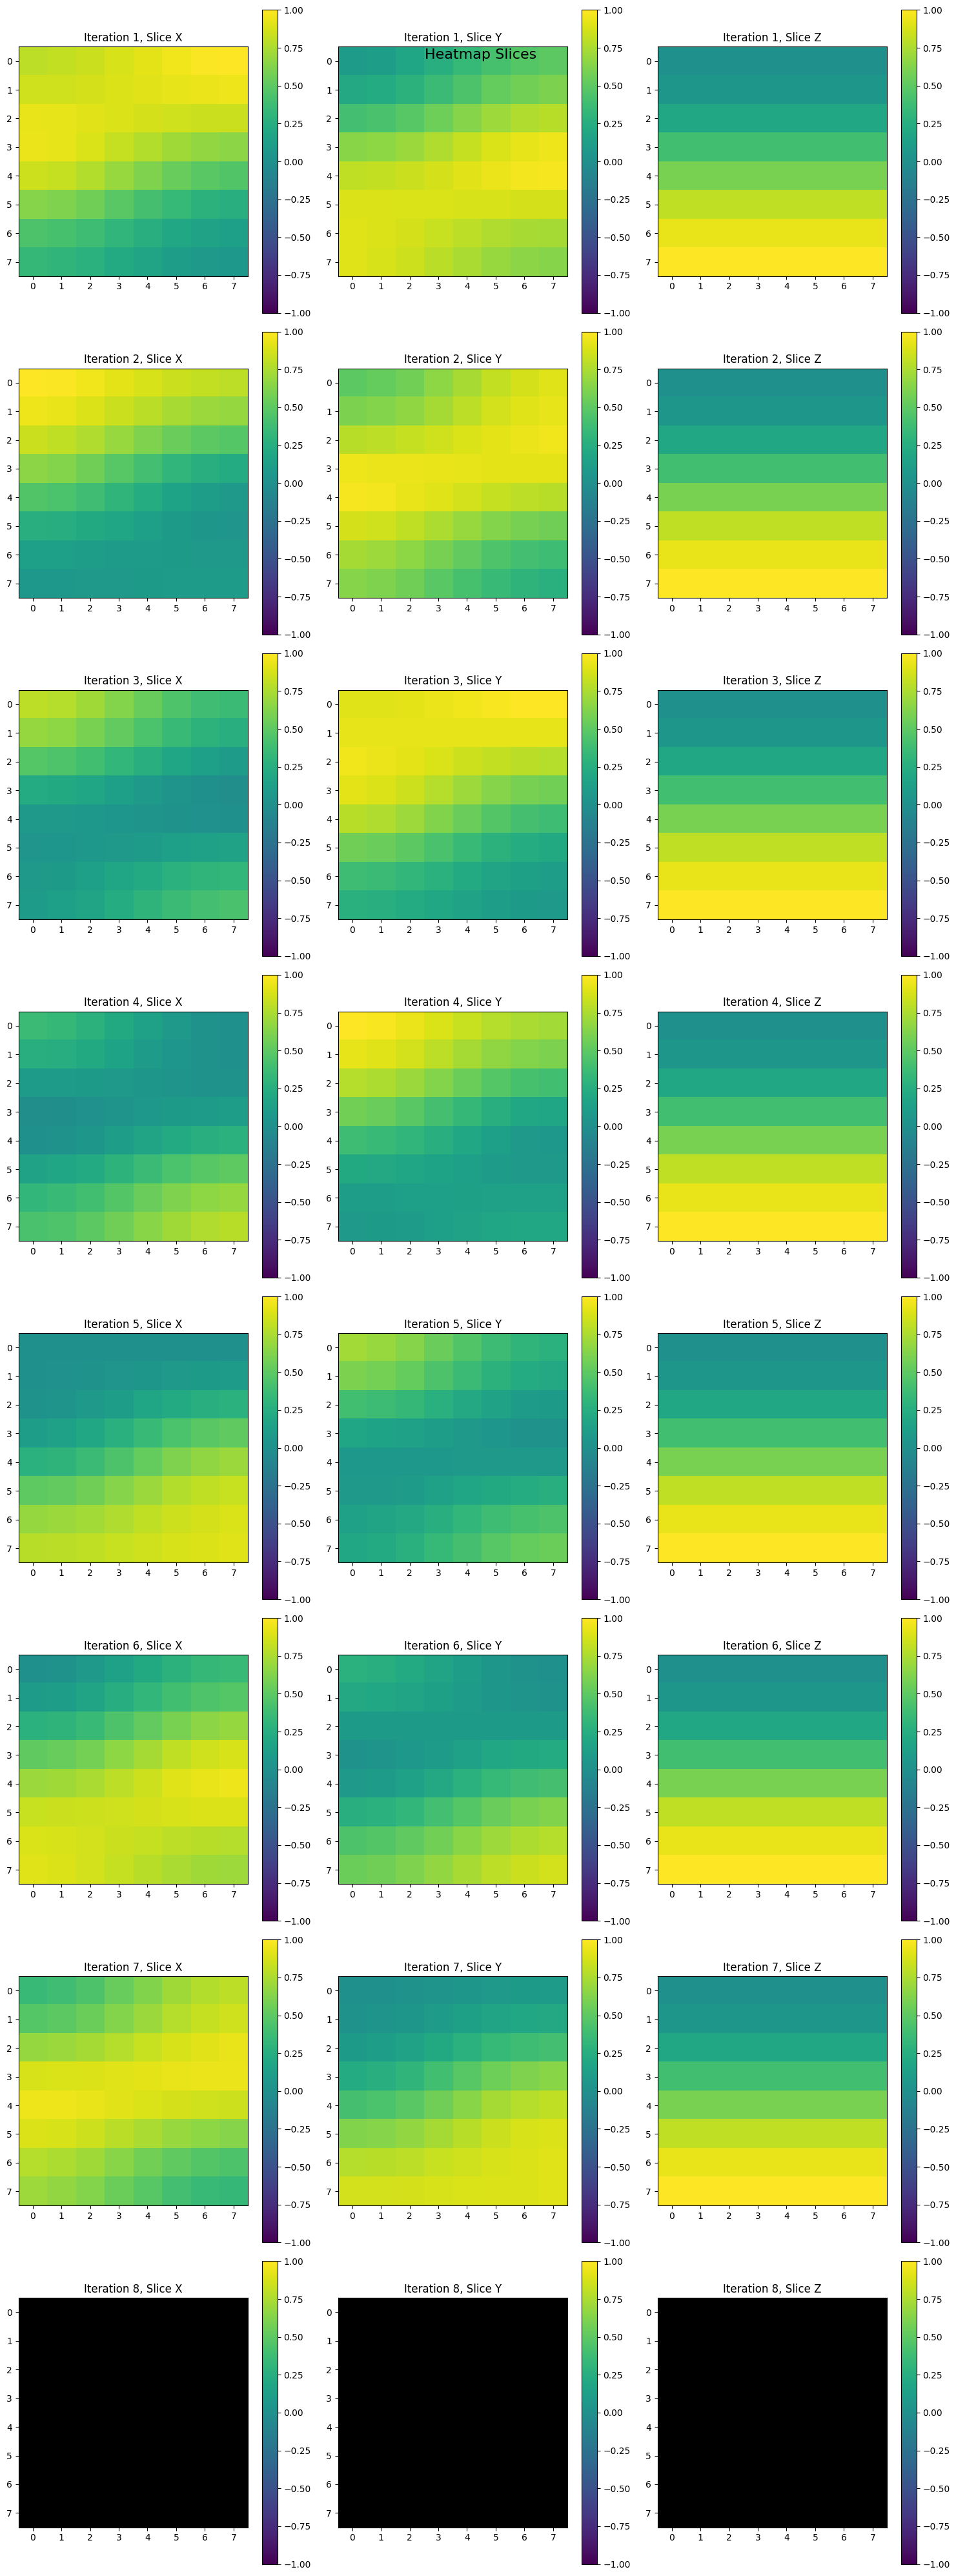

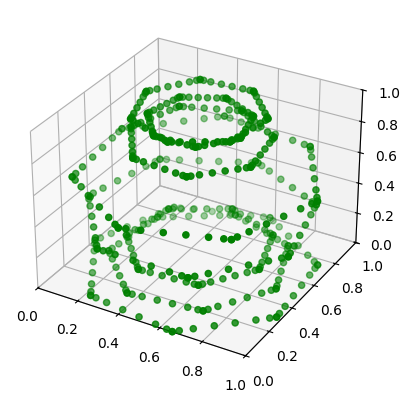

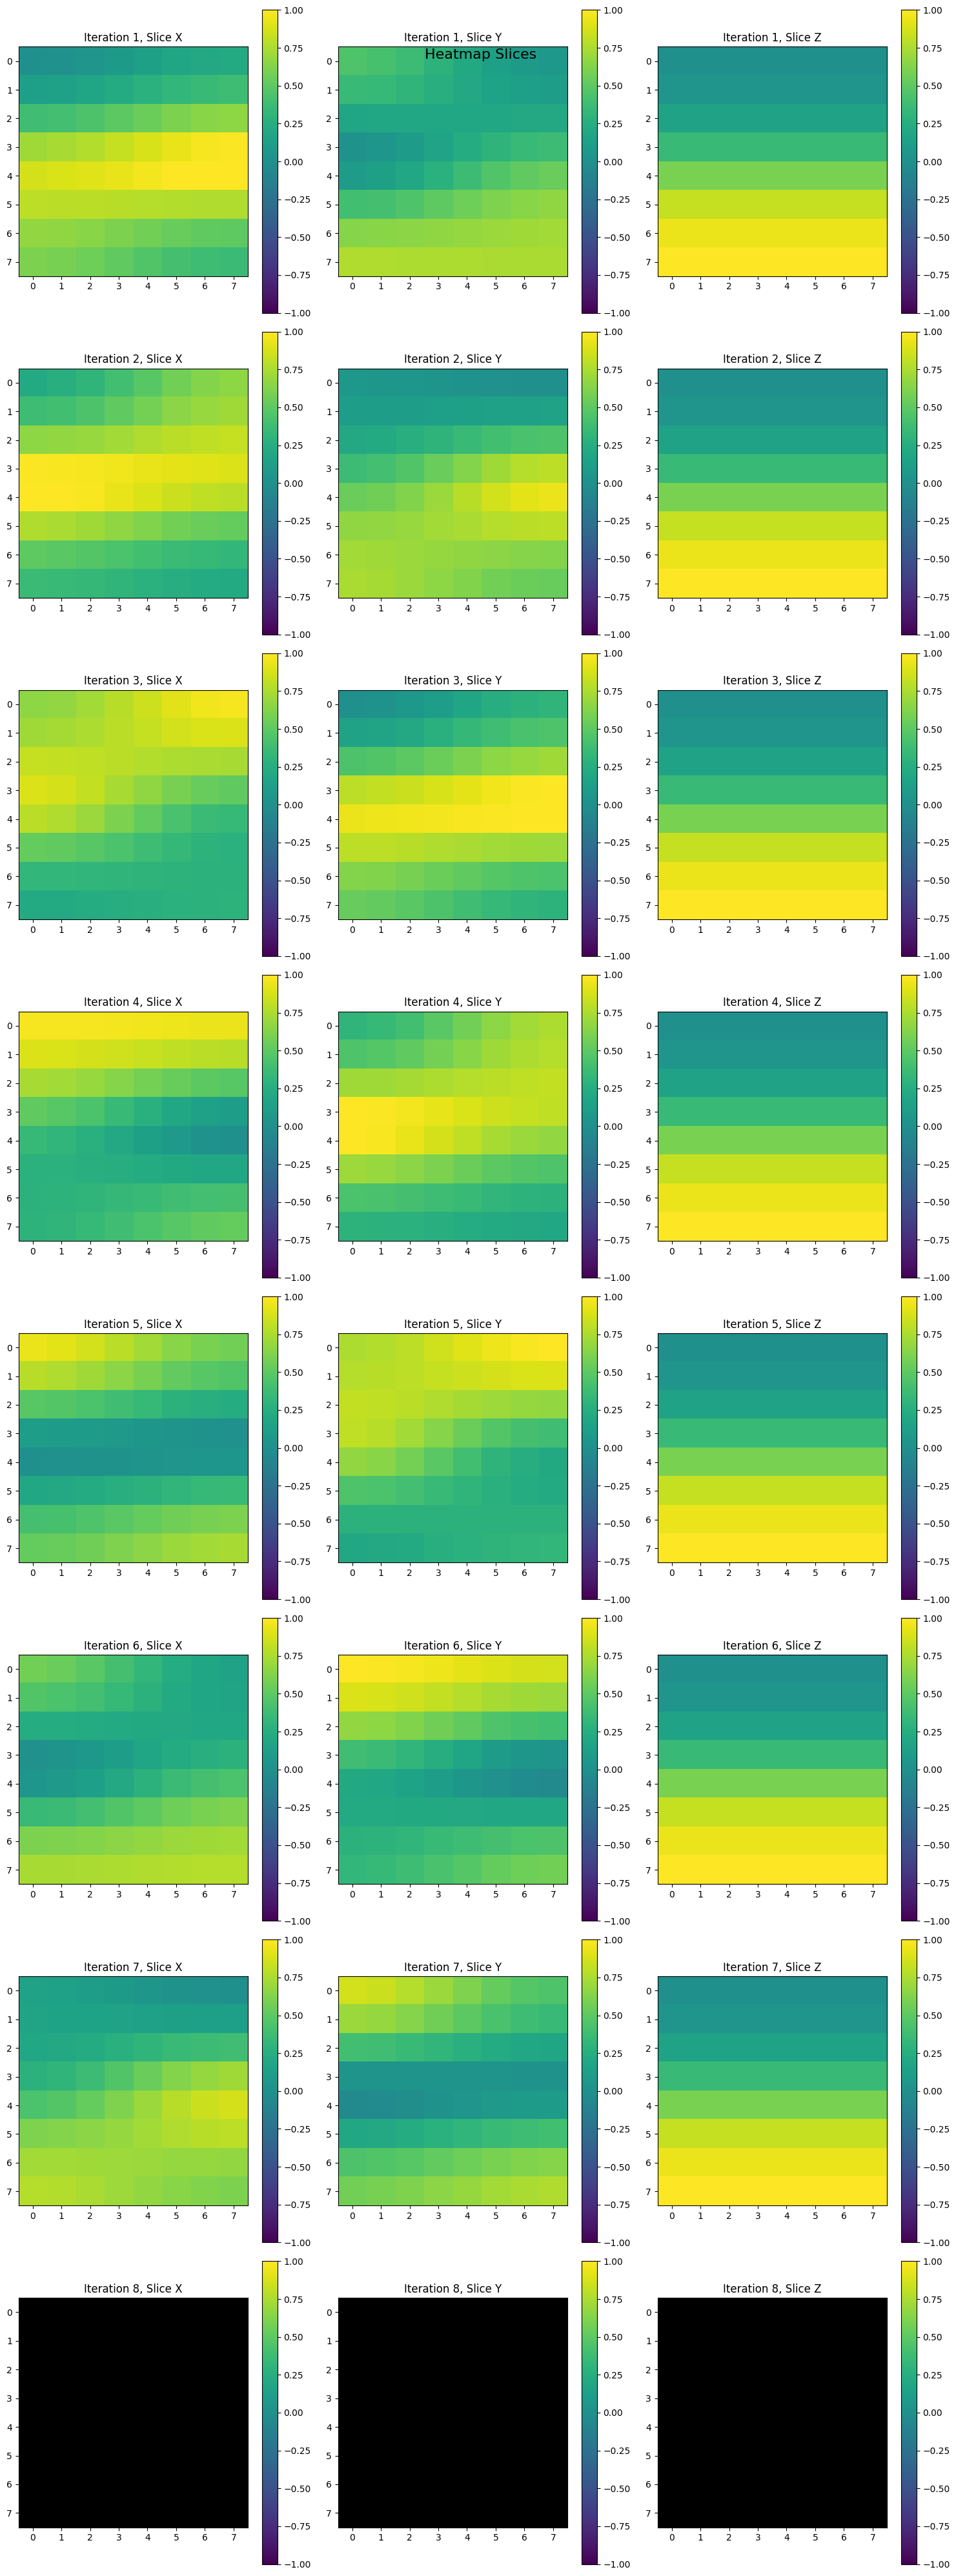

In [9]:
train_test_split = 0.9

test_data_percent = 1.0 - train_test_split

def dataloader(folder_path, expected_shape=(4,16,16) ):
    data = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.npy'):
                file_path = os.path.join(root, file)
                item = np.load(file_path)
                if item.shape == expected_shape:
                    data.append(item)
                else:
                    print(f"Skipping file {file} due to unexpected shape: {item.shape}")
    return data

# test dataloader

data = dataloader(folder_path, except_data_shape)

# split the data into train and test
random.shuffle(data)
train_data = data[:int(train_test_split*len(data))]
test_data = data[int(train_test_split*len(data)):]

#conveert the data to torch tensors and put them on the device
train_data = torch.tensor(train_data, dtype=torch.float32, device=device)
test_data = torch.tensor(test_data, dtype=torch.float32, device=device)

# Create TensorDatasets
train_dataset = TensorDataset(train_data)
test_dataset = TensorDataset(test_data)

# Create DataLoaders with shuffle=True
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(f"Number of training samples: {len(train_data)}")
print(f"Number of testing samples: {len(test_data)}")

# print some information about the data
random_index = random.randint(0, len(train_data))
print('Shape of the data: ', train_data[random_index].shape)
print('Type of the data: ', type(train_data[random_index]))
visualize_points(train_data[random_index])

visualize_heatmaps(train_data[random_index])

visualize_points(test_data[0], point_color='g')
visualize_heatmaps(test_data[0])
#print(test_data[0])

## Set Up AI Model

In [10]:
"""
# itterate through the train loader
for idx, data in enumerate(train_loader):
    print(data[0].shape)
    #isualize_heatmaps(data[0])
    break

for idx, data in enumerate(test_loader):
    print(data[0].shape)
    #visualize_heatmaps(data[0])
    break
"""

'\n# itterate through the train loader\nfor idx, data in enumerate(train_loader):\n    print(data[0].shape)\n    #isualize_heatmaps(data[0])\n    break\n\nfor idx, data in enumerate(test_loader):\n    print(data[0].shape)\n    #visualize_heatmaps(data[0])\n    break\n'

In [11]:
class VAE(nn.Module):

    def __init__(self, input_shape=(3, 16, 16), hidden_dims=[600,300,100], latent_dim=64, dropput_rate = 0.1, device=device):
        super(VAE, self).__init__()

        if len(input_shape) == 3:
            input_dim = input_shape[0] * input_shape[1] * input_shape[2]
        elif len(input_shape) == 4:
            input_dim = input_shape[0]* input_shape[1] * input_shape[2] * input_shape[3]
        else:
            raise ValueError("The input shape must be of length 3 or 4")

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(True),
            nn.Dropout(dropput_rate),

            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(True),
            nn.Dropout(dropput_rate),

            nn.Linear(hidden_dims[1], hidden_dims[2]),
            nn.ReLU(True),
            nn.Dropout(dropput_rate),

            nn.Linear(hidden_dims[2], latent_dim),
            nn.ReLU(True),
            nn.Dropout(dropput_rate)
            )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, latent_dim)
        self.logvar_layer = nn.Linear(latent_dim, latent_dim)


        if use_padded_data == True:
            self.final_activation = nn.Tanh()
        else:
            self.final_activation = nn.Sigmoid()

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.ReLU(True),
            nn.Dropout(dropput_rate),

            nn.Linear(latent_dim, hidden_dims[2]),
            nn.ReLU(True),
            nn.Dropout(dropput_rate),

            nn.Linear(hidden_dims[2], hidden_dims[1]),
            nn.ReLU(True),
            nn.Dropout(dropput_rate),

            nn.Linear(hidden_dims[1], hidden_dims[0]),
            nn.ReLU(True),
            nn.Dropout(dropput_rate),

            nn.Linear(hidden_dims[0], input_dim),
            self.final_activation
            )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        #print(x.shape)

        mean, logvar = self.encode(x)
        #print(mean.shape, logvar.shape)

        z = self.reparameterization(mean, logvar)
        #print("z", z.shape)
        x_hat = self.decode(z)
        #print("output shape", x_hat.shape)
        return x_hat, mean, logvar

if model_type == "VAE":
    model = VAE(input_shape=except_data_shape).to(device)
    x = torch.randn(batch_size, *except_data_shape).to(device)
    x = x.view(batch_size, -1)

    x_hat, mean, logvar = model(x)
    #print(x_hat.shape)
    #print(mean.shape)
    #print(logvar.shape)

    print("Number of parameters in the model: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
    print("Number of layers in the model: ", len(list(model.parameters())))



model = VAE(input_shape=except_data_shape, hidden_dims=number_of_neurons, latent_dim=latent_space_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print("Constrcting a VAE model")
print(model)

Number of parameters in the model:  2292080
Number of layers in the model:  22
Constrcting a VAE model
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=1536, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=128, out_features=32, bias=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.1, inplace=False)
  )
  (mean_layer): Linear(in_features=32, out_features=32, bias=True)
  (logvar_layer): Linear(in_features=32, out_features=32, bias=True)
  (final_activation): Tanh()
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=

In [12]:
def loss_function(x, x_hat, mean, log_var, kld_multiplier=1.0):
    # Reconstruction loss (Mean Squared Error)
    reproduction_loss = F.mse_loss(x_hat, x, reduction='sum')

    # Kullback-Leibler Divergence
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    # Total loss
    loss = reproduction_loss + KLD * kld_multiplier
    return loss

In [13]:
def train(model, optimizer, epochs, device):
    model.train()
    all_losses = []
    all_test_losses = []
    for epoch in range(epochs):
        overall_loss = 0
        #for input_data in train_loader:
        for idx, data in enumerate(train_loader):
            model.train()
            x = data[0].to(device)
            #flatten the input data
            x = x.view(x.size(0), -1)

            optimizer.zero_grad()

            if model_type == "VAE":
                x_hat, mean, log_var = model(x)
                loss = loss_function(x, x_hat, mean, log_var)

            elif model_type == "AE":
                x_hat = model(x)
                loss = F.mse_loss(x_hat, x, reduction='sum')
            else:
                raise ValueError("Model type must be either VAE or AE")

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        # perform validation on the test data
        model.eval()

        with torch.no_grad():
            test_loss = 0
            for idx, data in enumerate(test_loader):

                x = data[0].to(device)
                x = x.view(x.size(0), -1)

                if model_type == "VAE":
                    x_hat, mean, log_var = model(x)
                    loss = loss_function(x, x_hat, mean, log_var)
                elif model_type == "AE":
                    x_hat = model(x)
                    loss = F.mse_loss(x_hat, x, reduction='sum')
                else:
                    raise ValueError("Model type must be either VAE or AE")

                test_loss += loss.item()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / len(train_loader.dataset), "Validation Loss: ", test_loss / len(test_loader.dataset))
        all_losses.append(overall_loss / len(train_loader.dataset))
        all_test_losses.append(test_loss / len(test_loader.dataset))

    return all_losses, all_test_losses


## Train AI Model

In [14]:
if train_moedel == True:
    overall_loss, validation_loss =train(model, optimizer, epochs=epochs, device=device)

    if save_model:
        torch.save(model, os.path.join(save_model_location, model_name))

	Epoch 1 	Average Loss:  486.56256166843696 Validation Loss:  278.1123341256783
	Epoch 2 	Average Loss:  202.32597734864154 Validation Loss:  126.95882835265525
	Epoch 3 	Average Loss:  143.75603057915922 Validation Loss:  114.38357416379873
	Epoch 4 	Average Loss:  119.12157128731552 Validation Loss:  84.2377395875201
	Epoch 5 	Average Loss:  101.45168321640206 Validation Loss:  72.35880389934184
	Epoch 6 	Average Loss:  90.47048235024877 Validation Loss:  66.25339922644318
	Epoch 7 	Average Loss:  83.27195129940463 Validation Loss:  62.7243168576354
	Epoch 8 	Average Loss:  78.33640964351102 Validation Loss:  60.43503690762535
	Epoch 9 	Average Loss:  75.2684525109361 Validation Loss:  59.10838430717444
	Epoch 10 	Average Loss:  73.06029321332737 Validation Loss:  59.13600693484978
	Epoch 11 	Average Loss:  70.09234964169416 Validation Loss:  57.47827629261078
	Epoch 12 	Average Loss:  68.10707079728729 Validation Loss:  56.6319123786362
	Epoch 13 	Average Loss:  66.50330151061466 Va

### Visualize Training Graph

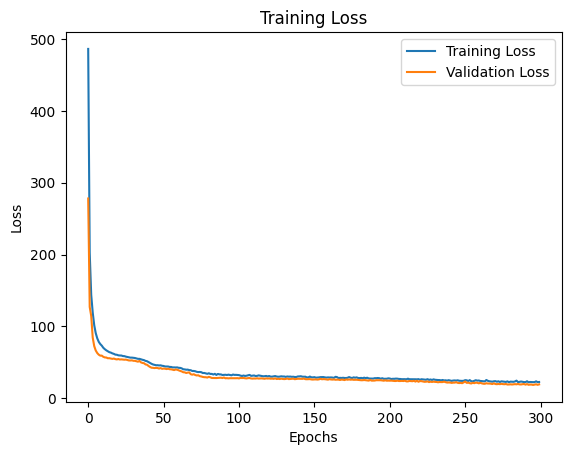

In [15]:
if train_moedel == True:
    #plot the loss
    plt.plot(overall_loss)
    plt.plot(validation_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.show()

##Test Trained Model

torch.Size([1, 8, 3, 8, 8])
Original Geometry


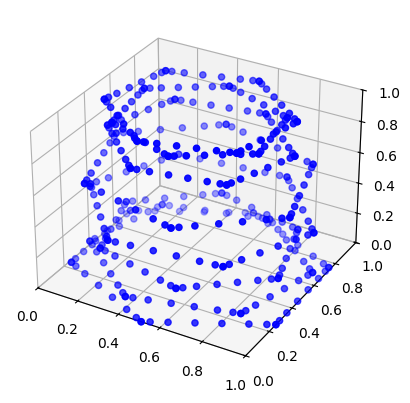

Reconsruced Geometry


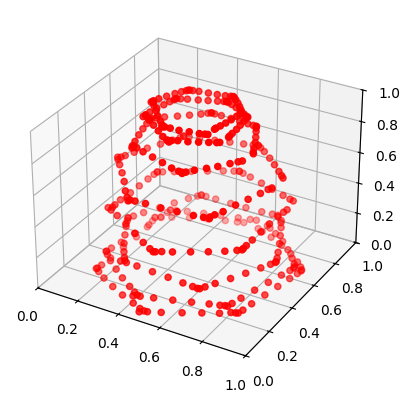

In [16]:
show_heatmaps = False # @param {type:"boolean"}
if train_moedel == True:
    # put the model in evaluation mode
    random_index = random.randint(0, len(test_data))

    model.eval()


    # perform reconstruction on the test data
    test_sample = test_data[random_index].unsqueeze(0)

    test_sample_flatten = torch.flatten(test_sample, start_dim=1)

    # AE
    if model_type == "AE":
        test_prediction = model(test_sample_flatten)

    #VAe
    if model_type == "VAE":
        test_prediction, _, _ = model(test_sample_flatten)

    test_prediction = test_prediction.view(test_sample.shape)
    print(test_prediction.shape)
    if is_poly_surface == True:
    #remove first dimension
        test_sample = test_sample.squeeze(0)
        test_prediction = test_prediction.squeeze(0)

    print("Original Geometry")
    visualize_points(test_sample)
    print("Reconsruced Geometry")
    visualize_points(test_prediction, point_color='r')

    if show_heatmaps == True:
      print("Original Heatmap")
      visualize_heatmaps(test_sample)
      print("Reconsruced Heatmap")
      visualize_heatmaps(test_prediction)

## Load AI Model

In [17]:
# load the saved model
loaded_model = torch.load(os.path.join(save_model_location, model_name), weights_only=False)
loaded_model.eval()
print("AI Model sucsefull loaded")

AI Model sucsefull loaded


### evalute loaded model

Latent space shape: (311, 32)
Latent space mean: [-0.05926311 -0.08677015 -0.0206923   0.03946227 -0.07212909  0.04083336
 -0.09195798  0.01649713  0.06377873 -0.02522725  0.02233372 -0.03605651
  0.02995569  0.03978938  0.03000217 -0.03619323 -0.00026739  0.0123247
 -0.00997343  0.1298589   0.06690852 -0.06547271  0.05663671  0.00290451
  0.05443571  0.04559315 -0.0641021  -0.01030548 -0.00553256  0.0461899
 -0.0260628  -0.05659115]
Latent space variance: [0.02450113 0.02427355 0.01399795 0.0055419  0.10771248 0.03861315
 0.03021995 0.04757243 0.01514129 0.02128077 0.05427811 0.02107011
 0.01579056 0.02972736 0.0559615  0.01919408 0.0396086  0.01859138
 0.09834003 0.04173379 0.02858335 0.00781328 0.06908636 0.0158335
 0.01586546 0.04257498 0.01222434 0.01872122 0.016952   0.03615171
 0.04902278 0.02848372]


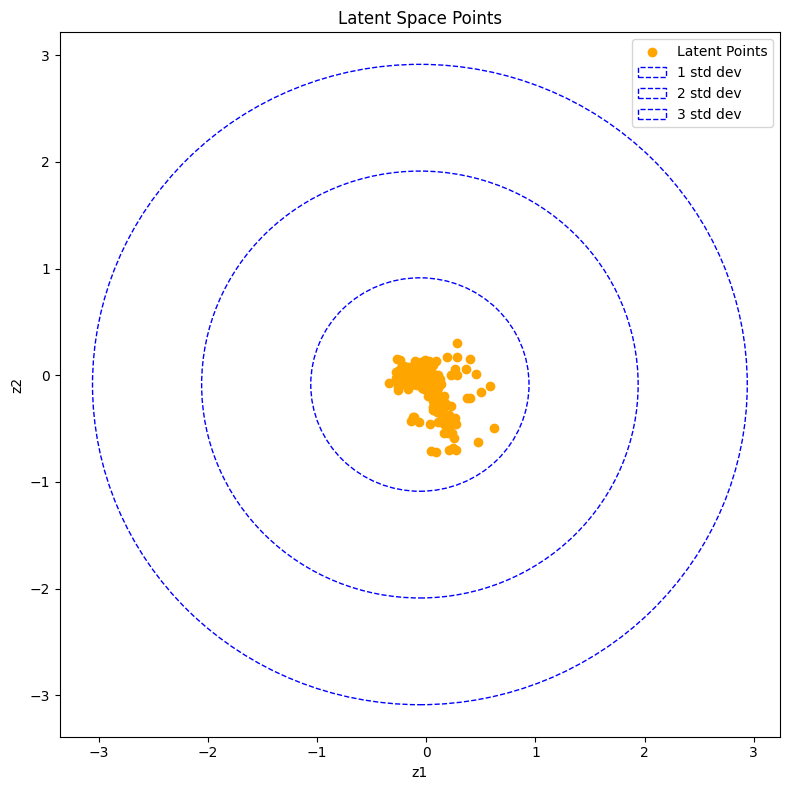

In [18]:
# plot the point distribution in the latent space



if model_type == "VAE":
    # Get the latent space representation of the test data
    latent_space = []
    for idx, data in enumerate(test_loader):
        x = data[0].to(device)
        x = x.view(x.size(0), -1)
        mean, logvar = loaded_model.encode(x)
        z = loaded_model.reparameterization(mean, logvar)
        latent_space.append(z.cpu().detach().numpy())
    latent_space = np.concatenate(latent_space, axis=0)
    print("Latent space shape:", latent_space.shape)

    # Calculate and print the mean and variance of the latent space points
    latent_mean = np.mean(latent_space, axis=0)
    latent_var = np.var(latent_space, axis=0)
    print("Latent space mean:", latent_mean)
    print("Latent space variance:", latent_var)

    # Plot the latent space in 2D
    fig, ax = plt.subplots()
    # set figuresize
    fig.set_size_inches(8, 8)
    ax.scatter(latent_space[:, 0], latent_space[:, 1], c='orange', label='Latent Points')

    # Add circles for 1, 2, and 3 standard deviations
    for std_dev in range(1, 4):
        circle = patches.Circle(latent_mean, std_dev, edgecolor='blue', facecolor='none', linestyle='--', label=f'{std_dev} std dev')
        ax.add_patch(circle)

    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Latent Space Points')
    plt.legend()
    plt.tight_layout()
    #save the plot
    #plt.savefig(os.path.join(save_model_location, 'surface_latent_space.png'))
    #print("Saved the latent space plot to: ", os.path.join(save_model_location, 'surface_latent_space.png'))
    plt.show()


Latent space shape: (311, 32)
Latent space mean: [-0.05813812 -0.08843842 -0.02110776  0.0403573  -0.07021852  0.04128058
 -0.09099483  0.0156942   0.06321277 -0.02598856  0.01960461 -0.03252092
  0.03068114  0.04257051  0.03103163 -0.03474041  0.00015119  0.0128127
 -0.00987151  0.13134347  0.06129505 -0.06361247  0.05948091  0.00313567
  0.05237804  0.04579512 -0.0654622  -0.00701478 -0.00907872  0.04949713
 -0.0284837  -0.05540697]
Latent space variance: [0.024954   0.02488093 0.01460779 0.00676609 0.10736821 0.04007344
 0.02871404 0.04807262 0.01462929 0.02203229 0.0565316  0.02243868
 0.0140772  0.02805851 0.058388   0.0201514  0.03916511 0.0185287
 0.09383933 0.04146542 0.02620116 0.00799217 0.06945419 0.01500355
 0.01808072 0.04282094 0.01236354 0.01947536 0.01498864 0.03699687
 0.04894463 0.03075346]


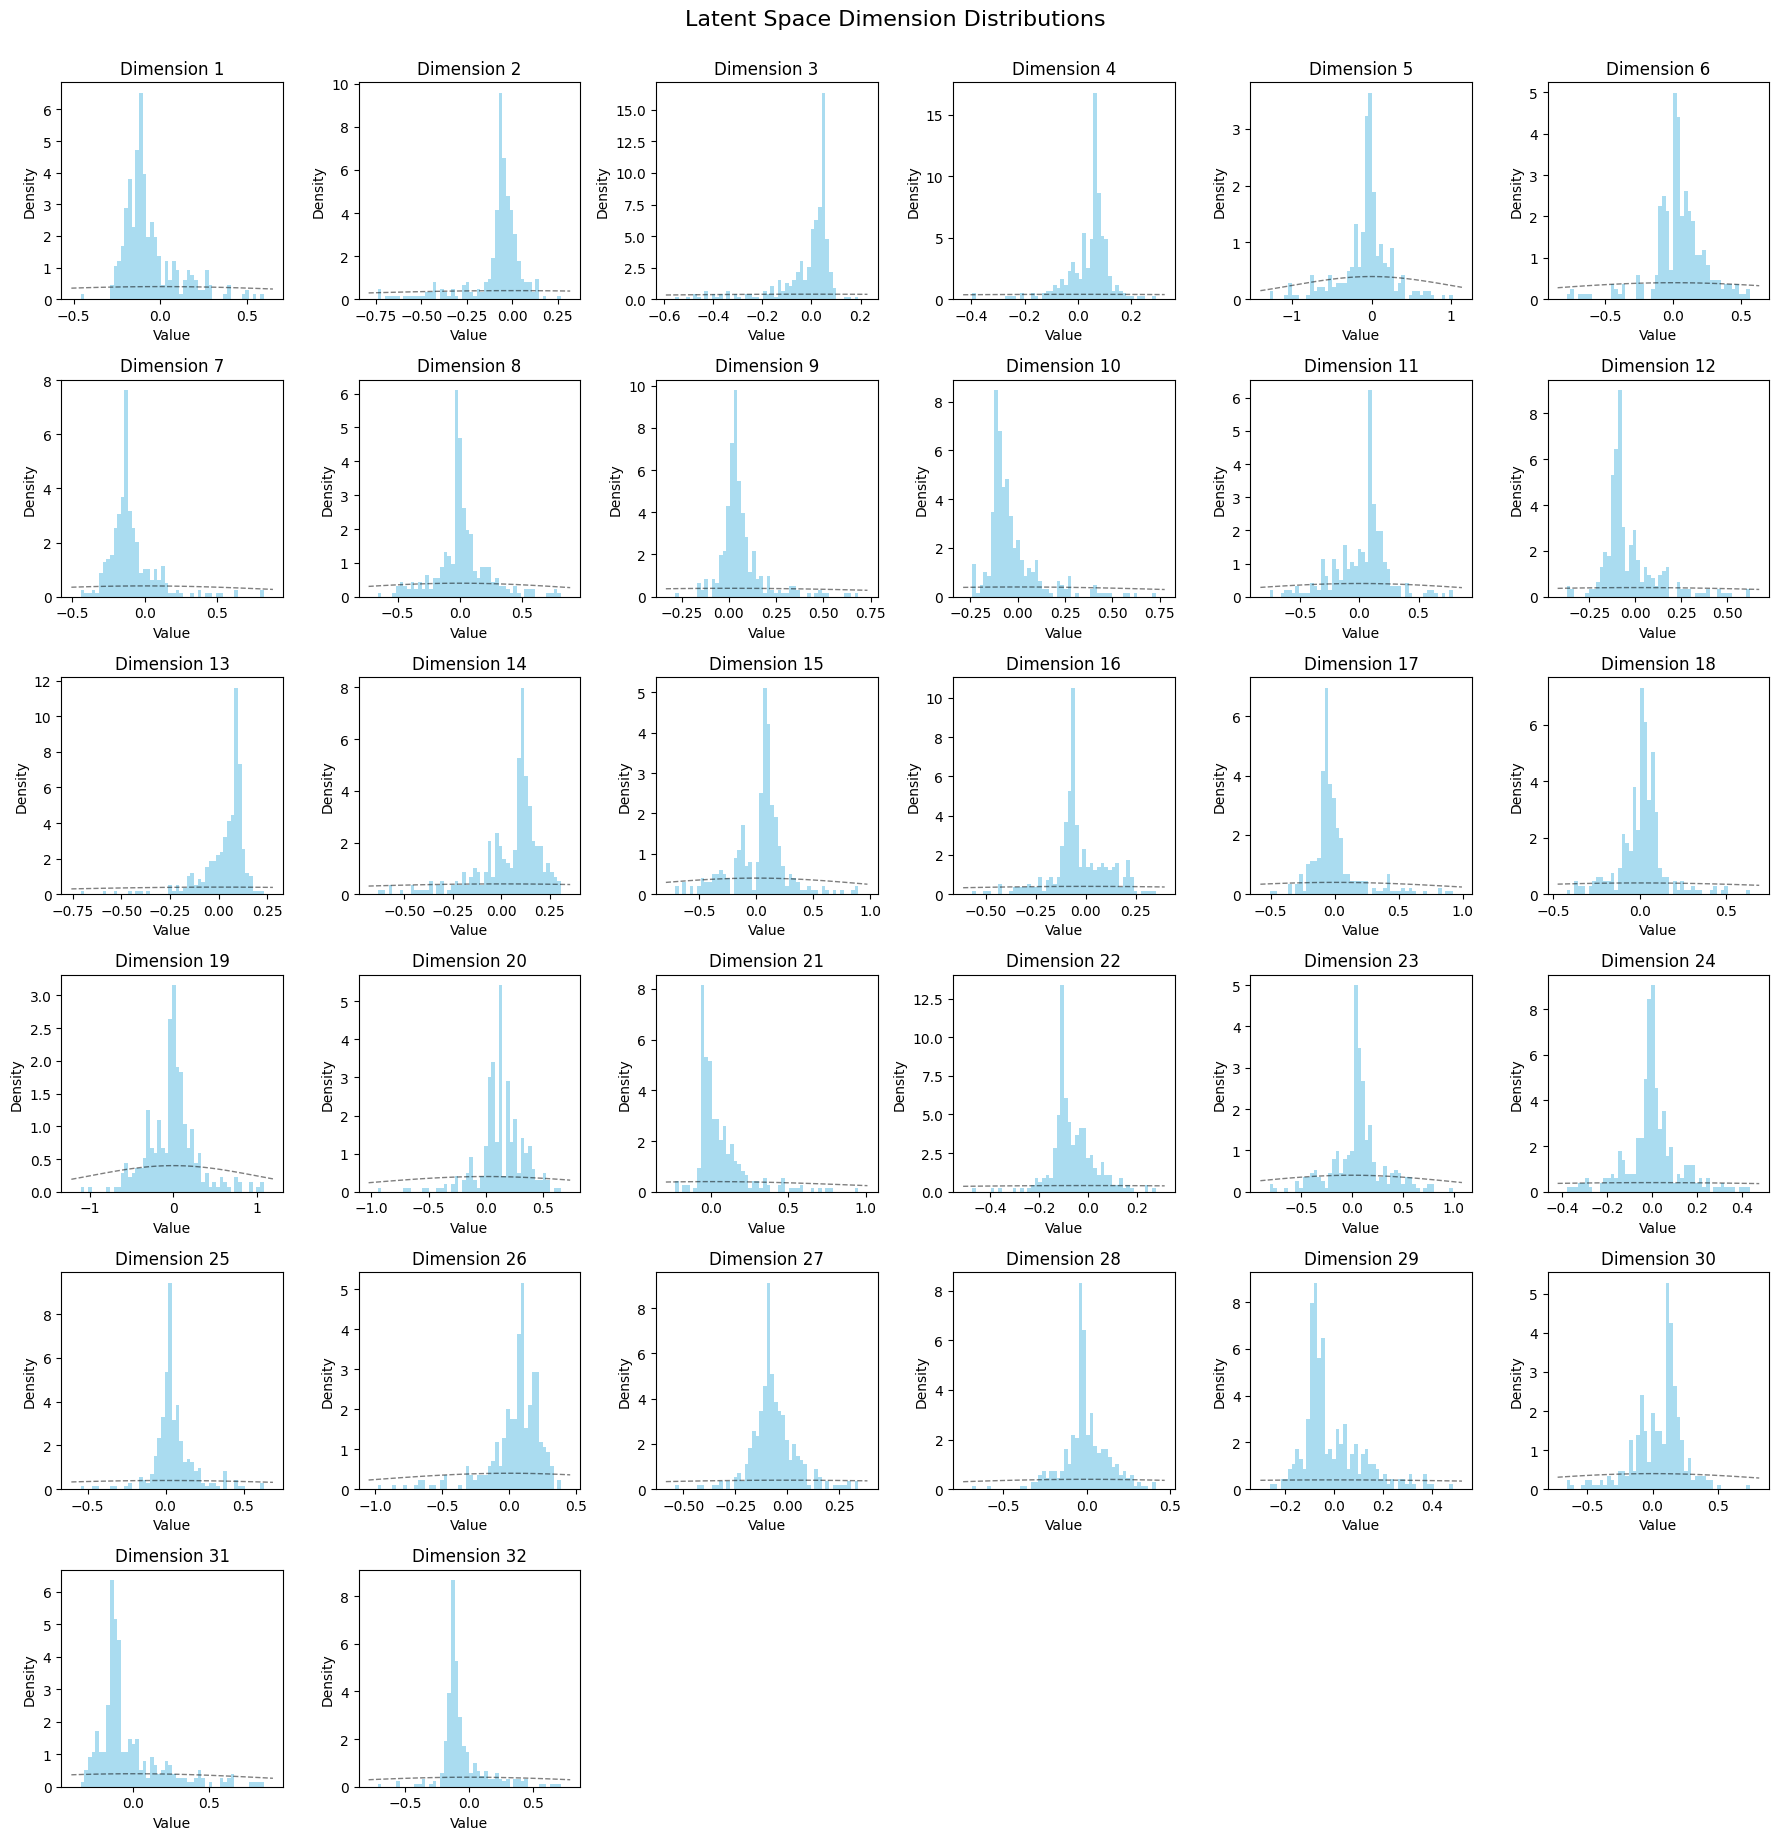

In [19]:
def visualize_latent_distribution(latent_space):
    """
    Visualizes the distribution of each dimension in the latent space using subplots.

    Args:
        latent_space (np.ndarray): A numpy array of shape (num_samples, latent_dim)
                                   containing the latent space representations.
    """
    latent_dim = latent_space.shape[1]
    num_rows = int(np.ceil(np.sqrt(latent_dim)))
    num_cols = int(np.ceil(latent_dim / num_rows))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
    axes = axes.flatten() # Flatten the axes array for easy iteration

    from scipy.stats import norm # Import norm here

    for i in range(latent_dim):
        ax = axes[i]
        ax.hist(latent_space[:, i], bins=50, density=True, alpha=0.7, color='skyblue')
        ax.set_title(f'Dimension {i+1}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        # Add a normal distribution curve for comparison
        # A perfectly trained VAE should have a latent space that follows a standard normal distribution (mean=0, variance=1)
        mu, std = 0, 1
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        ax.plot(x, p, 'k--', linewidth=1, alpha=0.5, label='Standard Normal') # Added label and adjusted line style


    # Hide any unused subplots
    for j in range(latent_dim, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle('Latent Space Dimension Distributions', y=1.02, fontsize=16)
    plt.show()

if model_type == "VAE":


    # Get the latent space representation of the test data
    latent_space = []
    for idx, data in enumerate(test_loader):
        x = data[0].to(device)
        x = x.view(x.size(0), -1)
        mean, logvar = loaded_model.encode(x)
        # You might choose to visualize the distribution of 'mean' or 'z' (reparameterization result)
        # Visualizing 'mean' shows the distribution of the predicted mean of the latent variable
        # Visualizing 'z' shows the actual samples from the latent space
        # Let's visualize 'z' as it represents the points the decoder will use
        z = loaded_model.reparameterization(mean, logvar)
        latent_space.append(z.cpu().detach().numpy())
    latent_space = np.concatenate(latent_space, axis=0)
    print("Latent space shape:", latent_space.shape)

    # Calculate and print the mean and variance of the latent space points
    latent_mean = np.mean(latent_space, axis=0)
    latent_var = np.var(latent_space, axis=0)
    print("Latent space mean:", latent_mean)
    print("Latent space variance:", latent_var)


    # Visualize the distribution of each latent dimension
    visualize_latent_distribution(latent_space)

##Generate new Geometries

In [20]:

number_of_new_geometry_to_create = 10 #@param {type:"integer"}

for i in range(10):
    z = torch.randn(1, latent_space_dim).to(device)
    #print(z.shape)
    x_hat = loaded_model.decode(z)
    x_hat = x_hat.view(1, *except_data_shape)
    #visualize_points(x_hat[0], point_color='purple')
    #visualize_heatmaps(x_hat[0])
    #convert the tensor to numpy
    x_hat_numpy = x_hat.cpu().detach().numpy()
    #remove first dim
    x_hat_numpy = x_hat_numpy.squeeze(0)
    #save the numpy array
    #print(x_hat_numpy.shape)
    np.save(os.path.join(save_geo_folder, f"{save_geo_name}_{i}.npy"), x_hat_numpy)
    print("Saved the generated geometry to: ", os.path.join(save_geo_folder, f"{save_geo_name}_{i}.npy"))

Saved the generated geometry to:  /content/drive/MyDrive/info_vis_AI_2025/geometries/My_first_AI_Model/New_Geometry_0.npy
Saved the generated geometry to:  /content/drive/MyDrive/info_vis_AI_2025/geometries/My_first_AI_Model/New_Geometry_1.npy
Saved the generated geometry to:  /content/drive/MyDrive/info_vis_AI_2025/geometries/My_first_AI_Model/New_Geometry_2.npy
Saved the generated geometry to:  /content/drive/MyDrive/info_vis_AI_2025/geometries/My_first_AI_Model/New_Geometry_3.npy
Saved the generated geometry to:  /content/drive/MyDrive/info_vis_AI_2025/geometries/My_first_AI_Model/New_Geometry_4.npy
Saved the generated geometry to:  /content/drive/MyDrive/info_vis_AI_2025/geometries/My_first_AI_Model/New_Geometry_5.npy
Saved the generated geometry to:  /content/drive/MyDrive/info_vis_AI_2025/geometries/My_first_AI_Model/New_Geometry_6.npy
Saved the generated geometry to:  /content/drive/MyDrive/info_vis_AI_2025/geometries/My_first_AI_Model/New_Geometry_7.npy
Saved the generated geom